In [18]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
import tensorflow as tf
import warnings


from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import get_scheduler
import evaluate
from tqdm.auto import tqdm
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, 
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

# Ignore Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
# Check cuda status
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


### Prepare dataset

In [20]:
# Webscraped twitter data
df = pd.read_csv('source data/users.csv')
df_main = pd.read_csv("cleaned data/cleaned_data_split.csv",index_col=0)
df_main['Handle'] = '@' + df_main['screen_name']

# Merge df and df_main
result = df.merge(df_main, on='Handle', how='inner')

# replace NaN values in 'Content' and 'description' with 'NA'
result_final = result.fillna({'Content': 'NA', 'description': 'NA'})

In [21]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Convert pandas DataFrame to Hugging Face dataset format
result_final = result_final[['Content', 'account_type']].reset_index(drop=True)
dataset = Dataset.from_pandas(result_final)

# Perform an 80-20 train-test split with a fixed random seed
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)

In [22]:
# Check max content length for padding
content_length = result_final['Content'].apply(lambda x: len(str(x).split()))
max_content_len = max(content_length)

print("Max length of content is: ", max_content_len)

Max length of content is:  64


### Tokenization

In [23]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Content"], padding="max_length", truncation=True, max_length=max_content_len)

# Tokenize the training and testing datasets
tokenized_train = train_test_split['train'].map(tokenize_function, batched=True)
tokenized_test = train_test_split['test'].map(tokenize_function, batched=True)

# Rename column 'account_type' to 'labels'
tokenized_train = tokenized_train.rename_column("account_type", "labels")
tokenized_test = tokenized_test.rename_column("account_type", "labels")

# Remove the 'Content' column from the tokenized datasets
tokenized_train = tokenized_train.remove_columns(["Content"])
tokenized_test = tokenized_test.remove_columns(["Content"])

# Set format for PyTorch
tokenized_train.set_format("torch", columns=["labels", "input_ids", "token_type_ids", "attention_mask"])
tokenized_test.set_format("torch", columns=["labels", "input_ids", "token_type_ids", "attention_mask"])

# Create a DatasetDict
tokenized_datasets = DatasetDict({
    "train": tokenized_train,
    "test": tokenized_test
})

# Check the structure of the DatasetDict
print(tokenized_datasets)

Map: 100%|██████████| 575/575 [00:00<00:00, 29520.36 examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2298
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 575
    })
})


In [24]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42)
eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

### Create DataLoader

In [25]:
batchsize=10
# Create Dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batchsize)
eval_dataloader = DataLoader(eval_dataset, batch_size=batchsize)

## Model Structure

### Define Model Architecture

In [26]:
class Model(nn.Module):
    def __init__(self,output_dim,dropout_rate):
        super(Model,self).__init__()
        self.encoder=AutoModelForMaskedLM.from_pretrained("bert-base-uncased", output_hidden_states=True, return_dict=True)
        self.dropout=nn.Dropout(dropout_rate)
        self.classifier=nn.Linear(3072,output_dim)

    def forward(self,input_ids,token_type_ids,attention_mask):
        outputs = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        hidden_states = torch.cat(tuple([outputs.hidden_states[i] for i in [-1, -2, -3, -4]]), dim=-1)

        x=self.dropout(hidden_states[:, 0, :])
        x=self.classifier(x)
        return x

### Create Model Instance

In [27]:
model = Model(output_dim=2, dropout_rate = 0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss_fct = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)

/Users/thiri/Downloads/bt4222/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training and Evaluation

In [28]:
epochs = 5
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
metric = evaluate.load("accuracy")
progress_bar = tqdm(range(num_training_steps))

100%|██████████| 1150/1150 [13:43:20<00:00, 42.96s/it]


In [29]:
all_true_labels = []
all_predictions = []

for epoch in range(epochs):
        for batch in train_dataloader:
            model.train()
            # Loop through batches in the training data loader
            batch = {k: v.to(device) for k, v in batch.items()}
            label_ids = batch['labels'].long()
            input_ids = batch['input_ids']
            token_type_ids = None
            attention_mask = batch['attention_mask']
            # Forward pass
            logits = model(input_ids, token_type_ids, attention_mask)
            
            # Calculate loss
            loss = loss_fct(logits, label_ids.view(-1))
            # Perform backward pass and update model parameters
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        true_labels = []
        predictions = []

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                label_ids = batch['labels'].long()
                input_ids = batch['input_ids']
                token_type_ids = None
                attention_mask = batch['attention_mask']
                logits = model(input_ids, token_type_ids, attention_mask)
                loss = loss_fct(logits, label_ids.view(-1))

            # Get predicted labels by selecting the class with the highest probability
            preds = torch.argmax(logits, dim=-1)
            
            metric.add_batch(predictions=preds, references=batch["labels"])

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(label_ids.cpu().numpy())
        
        all_true_labels.extend(true_labels)
        all_predictions.extend(predictions)

        acc = metric.compute()
        print(f'Epoch {epoch+1}')
        print(f'val_loss : {loss}')
        print(25*'==')

Epoch 1
val_loss : 0.9625318646430969


Epoch 2
val_loss : 1.0049210786819458


Epoch 3
val_loss : 1.1507232189178467


Epoch 4
val_loss : 2.6510112285614014


Epoch 5
val_loss : 2.579458713531494


### Performance Metrics

In [39]:
report = classification_report(all_true_labels, all_predictions, target_names=["Not Bot", "Bot"], labels=[0,1])
print("Final Classification Report:\n", report)

Final Classification Report:
               precision    recall  f1-score   support

     Not Bot       0.83      0.90      0.86      2185
         Bot       0.56      0.40      0.47       690

    accuracy                           0.78      2875
   macro avg       0.69      0.65      0.66      2875
weighted avg       0.76      0.78      0.77      2875



In [41]:
accuracy = accuracy_score(all_true_labels, all_predictions)
recall = recall_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions)
f1 = f1_score(all_true_labels, all_predictions)

print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("Precision: ", precision)
print("F1-Score:", f1)

Accuracy:  0.7801739130434783
Recall:  0.39855072463768115
Precision:  0.5589430894308943
F1-Score: 0.4653130287648054


### Confusion Matrix

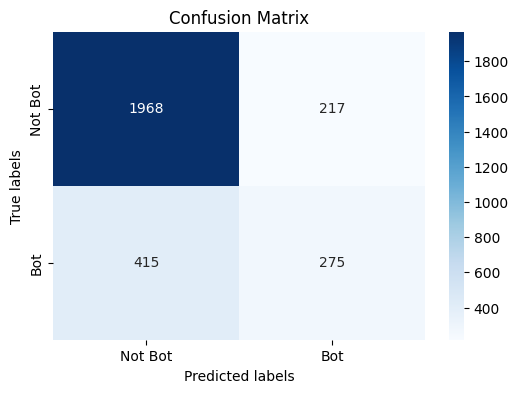

In [32]:
cm = confusion_matrix(all_true_labels, all_predictions)
labels = ["Not Bot", "Bot"]

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Replicability

In [34]:
# Save model
with open("output_files/content_sentiment_analysis_model.pkl", 'wb') as f:
    pickle.dump(model, f)

In [46]:
data = [
    {
        'model': 'Sentiment Analysis on Webscraped Data',
        'test_metrics': {
            'accuracy': accuracy,
            'recall' : recall,
            'precision' : precision,
            'f1_score' : f1
        }
    }
]
df_results = pd.DataFrame(data)

# Save to CSV
df_results.to_csv('output_files/model_results_content_sentiment_analysis.csv', index=False)